In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import os
import argparse
import importlib

import pathlib
import sys
sys.path.append('../')
# Try again
from models.network import ImageAutoEncoderEndToEnd, AutoEncoder

from train.implicit_trainer import Trainer
from data.data import ImNetAllDataSamples
from torch.utils.data import DataLoader
from utils.debugger import MyDebugger

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
## import config here
resume_path = '../configs/config_image_test.py'

spec = importlib.util.spec_from_file_location('*', resume_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [8]:
## import config here
spec = importlib.util.spec_from_file_location('*', resume_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

config.auto_encoder_config_path = os.path.join('../', config.auto_encoder_config_path)
config.auto_encoder_resume_path = os.path.join('../', config.auto_encoder_resume_path)

auto_spec = importlib.util.spec_from_file_location('*', config.auto_encoder_config_path)
auto_config = importlib.util.module_from_spec(auto_spec)
auto_spec.loader.exec_module(auto_config)

network = AutoEncoder(config,)
network = network.to(device)

### create dataset
network_state_dict = torch.load(config.auto_encoder_resume_path)
network_state_dict = ImageAutoEncoderEndToEnd.process_state_dict(network_state_dict, type = 1)
voxel_auto_encoder = AutoEncoder(auto_config)
voxel_auto_encoder.load_state_dict(network_state_dict)
voxel_auto_encoder.to(device)
_ = voxel_auto_encoder.eval()

In [9]:
_ = network.decoder.load_state_dict(voxel_auto_encoder.decoder.state_dict())

In [6]:
## folder for testing
is_svr = True
epoch = 1000
use_phase = False
phase = 2

testing_folder = r'./../pretrain/origin/' + ('image_encoder/' if is_svr else 'phase_2_model')
config_path = os.path.join(testing_folder, 'config.py')
network_path = os.path.join(testing_folder, f'model_epoch{"_" + str(phase) if use_phase and not is_svr else ""}_{epoch}.pth')

In [14]:
any(['image_encoder' in name_layer for name_layer in network_state_dict.keys()])

True

In [16]:
'image_encoder'[:13]

'image_encoder'

In [37]:
network_state_dict = torch.load(network_path)
# Saved with multi-gpu, clear it
for key, item in list(network_state_dict.items()):
    # Saved with multi-gpu
    if key.startswith('module.'):
        network_state_dict[key[len('module.'):]] = item
        del network_state_dict[key]

if any([name_layer.startswith('image_encoder.') for name_layer in network_state_dict.keys()]):
    # Delete encoder of older model
    for name_layer in list(network_state_dict.keys()):
        if name_layer.startswith('encoder.') or name_layer.startswith('auto_encoder.encoder'):
            print(f'delete {name_layer}')
            del network_state_dict[name_layer]

    for key, item in list(network_state_dict.items()):
        if key.startswith('image_encoder.'):
            # We should swap `image_encoder` to `encoder`
            new_key = 'encoder.' + key[len('image_encoder.'):]
            network_state_dict[new_key] = item
            del network_state_dict[key]
        if key.startswith('auto_encoder.decoder.'):
            # We should swap `image_encoder` to `encoder`
            new_key = 'decoder.' + key[len('auto_encoder.decoder.'):]
            network_state_dict[new_key] = item
            del network_state_dict[key]
network.load_state_dict(network_state_dict)
_ = network.eval()

delete auto_encoder.encoder.conv_1.weight
delete auto_encoder.encoder.conv_1.bias
delete auto_encoder.encoder.conv_2.weight
delete auto_encoder.encoder.conv_2.bias
delete auto_encoder.encoder.conv_3.weight
delete auto_encoder.encoder.conv_3.bias
delete auto_encoder.encoder.conv_4.weight
delete auto_encoder.encoder.conv_4.bias
delete auto_encoder.encoder.conv_5.weight
delete auto_encoder.encoder.conv_5.bias


In [1]:
import numpy as np
import random
import torch
import importlib
import os
import argparse
import pathlib
import sys
sys.path.append('../')
from models.network import AutoEncoder


from data.data import ImNetImageSamples, ImNetSamples
from torch.multiprocessing import Pool, Process, set_start_method

from evaluation.eval_utils import sample_points_polygon_vox64_njit
from utils.other_utils import write_ply_point_normal

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device_id = 1
config_path = '../pretrain/class_run_1/image_encoder/config.py'
network_path = '../pretrain/class_run_1/image_encoder/model_epoch_1000.pth'

In [3]:
torch.cuda.set_device(device_id)
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [4]:
network_state_dict = torch.load(network_path)

In [5]:
list(network_state_dict.keys())

['module.image_encoder.conv_0.weight',
 'module.image_encoder.res_1.conv_1.weight',
 'module.image_encoder.res_1.conv_2.weight',
 'module.image_encoder.res_2.conv_1.weight',
 'module.image_encoder.res_2.conv_2.weight',
 'module.image_encoder.res_3.conv_1.weight',
 'module.image_encoder.res_3.conv_2.weight',
 'module.image_encoder.res_3.conv_s.weight',
 'module.image_encoder.res_4.conv_1.weight',
 'module.image_encoder.res_4.conv_2.weight',
 'module.image_encoder.res_5.conv_1.weight',
 'module.image_encoder.res_5.conv_2.weight',
 'module.image_encoder.res_5.conv_s.weight',
 'module.image_encoder.res_6.conv_1.weight',
 'module.image_encoder.res_6.conv_2.weight',
 'module.image_encoder.res_7.conv_1.weight',
 'module.image_encoder.res_7.conv_2.weight',
 'module.image_encoder.res_7.conv_s.weight',
 'module.image_encoder.res_8.conv_1.weight',
 'module.image_encoder.res_8.conv_2.weight',
 'module.image_encoder.conv_9.weight',
 'module.image_encoder.conv_9.bias',
 'module.image_encoder.conv_10

In [6]:
network_state_dict, is_old_style_weights = AutoEncoder.process_state_dict(network_state_dict, type = 1)
if is_old_style_weights:
    # Old style weights (Image encoder) has wrong name for encoder type
    config = AutoEncoder.fix_old_weights_config(config)

old style weights


In [7]:
network = AutoEncoder(config=config).cuda(device_id)

In [8]:
network.decoder.bsp_field.convex_layer_weights[:10, :2]

tensor([[ 0.0353,  0.0127],
        [ 0.0161,  0.0119],
        [ 0.0354,  0.0040],
        [ 0.0010,  0.0123],
        [ 0.0045,  0.0019],
        [ 0.0169,  0.0043],
        [ 0.0024,  0.0342],
        [ 0.0258, -0.0098],
        [-0.0166, -0.0029],
        [ 0.0128, -0.0188]], device='cuda:1', grad_fn=<SliceBackward0>)

In [9]:
network.load_state_dict(network_state_dict)
_ = network.eval()

In [10]:
samples = ImNetImageSamples(
    data_path='../data/all_vox256_img_with_classes/all_vox256_img_test.hdf5', 
    label_txt_path='../data/all_vox256_img_with_classes/all_vox256_img_test.txt',
    image_idx=23, # Last image, stick to BSP-Net calc
    use_depth=False,
    image_preferred_color_space=1
)

In [11]:
sample_interval = 1
resolution = 64
max_batch = 20000
thershold = 0.01
with_surface_point = True # TODO: Is it needed here?
space_range = (-0.5, 0.5)

aggregate_embedding = False

In [12]:
def get_input_data(samples, i, num_input_data_aggregation, aggregate_embedding, view_use_indx_list):
    if aggregate_embedding:
        if num_input_data_aggregation is not None and num_input_data_aggregation == -1 and view_use_indx_list is None:
            indx_view_iterator = range(samples.view_num)
        elif view_use_indx_list is not None and len(view_use_indx_list) > 0:
            indx_view_iterator = view_use_indx_list
        else:
            return [samples[i][0][0] for _ in range(num_input_data_aggregation)]
        gathered_data_list = []
        for indx_view in indx_view_iterator:
            samples.image_idx = indx_view
            gathered_data_list.append(
                samples[i][0][0]
            )
        # Can be set to None, we dont care here about value 23 
        samples.image_idx = None
        return gathered_data_list

    return samples[i][0][0]

generate_args = [
    (
        get_input_data(samples, i, None, False, None), 
        os.path.join('../debug/test', samples.obj_paths[i]), 
        resolution, max_batch, (-0.5, 0.5), 
        thershold, with_surface_point
    ) 
    for i in range(10) if i % sample_interval == 0]
random.shuffle(generate_args)

(<matplotlib.image.AxesImage at 0x7f5f8404a7f0>, '../debug/test/gen_test_obj')

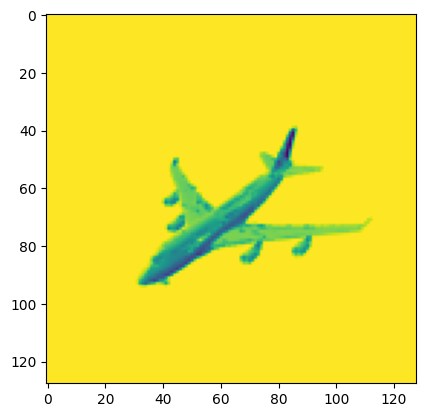

In [16]:
import matplotlib.pyplot as plt

input_data, store_file_path = generate_args[0][:2]
store_file_path = '../debug/test/gen_test_obj'

plt.imshow(input_data[0]), store_file_path

In [17]:
input_data.shape

(1, 128, 128)

In [18]:
if not isinstance(input_data, list) or (isinstance(input_data, list) and len(input_data) == 1):
    input_data = torch.from_numpy(input_data[0] if isinstance(input_data, list) else input_data).float().cuda(device_id)
    result = network.save_bsp_deform(
        inputs=input_data, file_path=store_file_path, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=None,
        return_voxel_and_values=True
    )
elif len(input_data) > 1 and aggregate_embedding:
    embeddings_list = []
    for input_data_single in input_data:
        input_data_single = torch.from_numpy(input_data_single).float().cuda(device_id)
        input_data_single = input_data_single.unsqueeze(0)
        embeddings_list.append(
            network(input_data_single)
        )
    embedding = torch.stack(embeddings_list).mean(dim=0) # TODO: mean or median?
    result = network.save_bsp_deform(
        inputs=None, file_path=store_file_path, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=embedding,
        return_voxel_and_values=True
    )
else:
    raise Exception('Unknown mode for network.')

In [2]:
config_path = '../pretrain/class_run_1/image_encoder/config.py'
network_path = '../pretrain/class_run_1/image_encoder/model_epoch_1000.pth'

In [3]:
spec = importlib.util.spec_from_file_location('*', config_path)
config = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config)

In [71]:
network_state_dict = torch.load(network_path)

In [ ]:
list(network_state_dict.keys())

In [72]:
network_state_dict, is_old_style_weights = AutoEncoder.process_state_dict(network_state_dict, type = 1)
if is_old_style_weights:
    config = AutoEncoder.fix_old_weights_config(config)

old style weights


In [ ]:
list(network_state_dict.keys())

In [73]:
network = AutoEncoder(config=config)

In [74]:
network.encoder.res_3.conv_1.weight[0, 0]

tensor([[ 0.0053, -0.0220, -0.0402],
        [ 0.0144,  0.0106,  0.0031],
        [-0.0559,  0.0297,  0.0155]], grad_fn=<SelectBackward0>)

In [75]:
res = network.load_state_dict(network_state_dict)
network = network.to(device)
_ = network.eval()

In [77]:
network.encoder.res_3.conv_1.weight[0, 0]

tensor([[ 0.0401,  0.0629,  0.0790],
        [ 0.0539,  0.0378,  0.0276],
        [ 0.0231, -0.0094, -0.0343]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [12]:
network.decoder.bsp_field.convex_layer_weights[:10, :2]

tensor([[ 9.9997e-01, -3.0198e-05],
        [ 1.6074e-06,  1.4381e-05],
        [-1.5459e-05,  3.1323e-05],
        [-1.0903e-05, -5.7974e-06],
        [-1.4553e-05,  1.0000e+00],
        [ 9.9999e-01,  9.9999e-01],
        [-1.7137e-05, -4.5415e-06],
        [-2.4085e-06,  1.5711e-05],
        [-1.9372e-05, -1.6469e-05],
        [ 4.5245e-06,  8.1758e-06]], device='cuda:0', grad_fn=<SliceBackward0>)

In [13]:
samples = ImNetImageSamples(
    data_path='../data/all_vox256_img_with_classes/all_vox256_img_test.hdf5', 
    label_txt_path='../data/all_vox256_img_with_classes/all_vox256_img_test.txt',
    image_idx=23, # Last image, stick to BSP-Net calc
    use_depth=False,
    image_preferred_color_space=1
)

In [14]:
sample_interval = 1
resolution = 64
max_batch = 20000
thershold = 0.01
with_surface_point = True # TODO: Is it needed here?
space_range = (-0.5, 0.5)

aggregate_embedding = False

In [15]:
def get_input_data(samples, i, num_input_data_aggregation, aggregate_embedding, view_use_indx_list):
    if aggregate_embedding:
        if num_input_data_aggregation is not None and num_input_data_aggregation == -1 and view_use_indx_list is None:
            indx_view_iterator = range(samples.view_num)
        elif view_use_indx_list is not None and len(view_use_indx_list) > 0:
            indx_view_iterator = view_use_indx_list
        else:
            return [samples[i][0][0] for _ in range(num_input_data_aggregation)]
        gathered_data_list = []
        for indx_view in indx_view_iterator:
            samples.image_idx = indx_view
            gathered_data_list.append(
                samples[i][0][0]
            )
        # Can be set to None, we dont care here about value 23 
        samples.image_idx = None
        return gathered_data_list

    return samples[i][0][0]

generate_args = [
    (
        get_input_data(samples, i, None, False, None), 
        os.path.join('../debug/test', samples.obj_paths[i]), 
        resolution, max_batch, (-0.5, 0.5), 
        thershold, with_surface_point
    ) 
    for i in range(10) if i % sample_interval == 0]
random.shuffle(generate_args)

(<matplotlib.image.AxesImage at 0x7f546f13af70>,
 '../debug/test/gen_test_obj',
 '02691156/d18592d9615b01bbbc0909d98a1ff2b4')

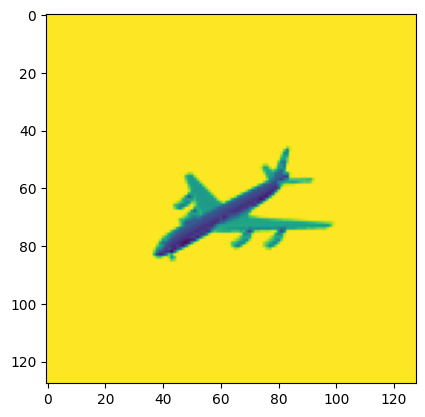

In [78]:
import matplotlib.pyplot as plt

input_data = samples.data_pixels[0, 0] / 255.0 # generate_args[0][0] samples.data_pixels[0, 0] / 255.0
store_file_path = '../debug/test/gen_test_obj'

plt.imshow(input_data[0]), store_file_path, samples.obj_paths[0]

In [57]:
input_data.shape

(1, 128, 128)

In [49]:
if not isinstance(input_data, list) or (isinstance(input_data, list) and len(input_data) == 1):
    input_data = torch.from_numpy(input_data[0] if isinstance(input_data, list) else input_data).float().to(device)
    result = network.save_bsp_deform(
        inputs=input_data, file_path=store_file_path, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=None,
        return_voxel_and_values=True
    )
elif len(input_data) > 1 and aggregate_embedding:
    embeddings_list = []
    for input_data_single in input_data:
        input_data_single = torch.from_numpy(input_data_single).float().to(device)
        input_data_single = input_data_single.unsqueeze(0)
        embeddings_list.append(
            network(input_data_single)
        )
    embedding = torch.stack(embeddings_list).mean(dim=0) # TODO: mean or median?
    result = network.save_bsp_deform(
        inputs=None, file_path=store_file_path, resolution=resolution, max_batch=max_batch,
        space_range=space_range, thershold_1=thershold, embedding=embedding,
        return_voxel_and_values=True
    )
else:
    raise Exception('Unknown mode for network.')

In [79]:
embedding = network(torch.from_numpy(input_data).float().to(device).unsqueeze(0))
(vertices, polygons, vertices_deformed, polygons_deformed, 
 embedding, vertices_convex, bsp_convex_list, pd_class,
 convex_predictions_sum, point_value_prediction) = network.save_bsp_deform(
    inputs=None, file_path=None, resolution=resolution, max_batch=max_batch,
    space_range=space_range, thershold_1=thershold, embedding=embedding,
    return_voxel_and_values=True, save_output=False
)

In [80]:
embedding.mean(), embedding.std()

(tensor(0.5000, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.4448, device='cuda:0', grad_fn=<StdBackward0>))

In [81]:
embedding[0, :10]

tensor([9.9942e-01, 9.9998e-01, 1.0000e+00, 1.0000e+00, 9.9990e-01, 9.9998e-01,
        9.9999e-01, 4.0829e-01, 1.5275e-05, 1.0000e+00], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [82]:
from utils.other_utils import write_ply_polygon

write_ply_polygon('mesh_deformed.ply', vertices_deformed, polygons_deformed)
write_ply_polygon('mesh_orginal.ply', vertices, polygons)